In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# print(sys.executable)
# !python -m pip install "kagglehub[pandas-datasets]" matplotlib matplotlib-inline seaborn scikit-learn


# Import Our Dataset

In [88]:
df = pd.read_csv("online_gaming_behavior_dataset.csv")
df.head()


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium


## Inspect our Dataset

In [ ]:
df.shape
df.info()
df.describe(include='all')
print("\nMissing values per column:")
df.isnull().sum()
print("\nEngagement Level distribution:")
print(df["EngagementLevel"].value_counts())
df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

Index(['PlayerID', 'Age', 'Gender', 'Location', 'GameGenre', 'PlayTimeHours',
       'InGamePurchases', 'GameDifficulty', 'SessionsPerWeek',
       'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked',
       'EngagementLevel'],
      dtype='object')

## Visualizing Our Features

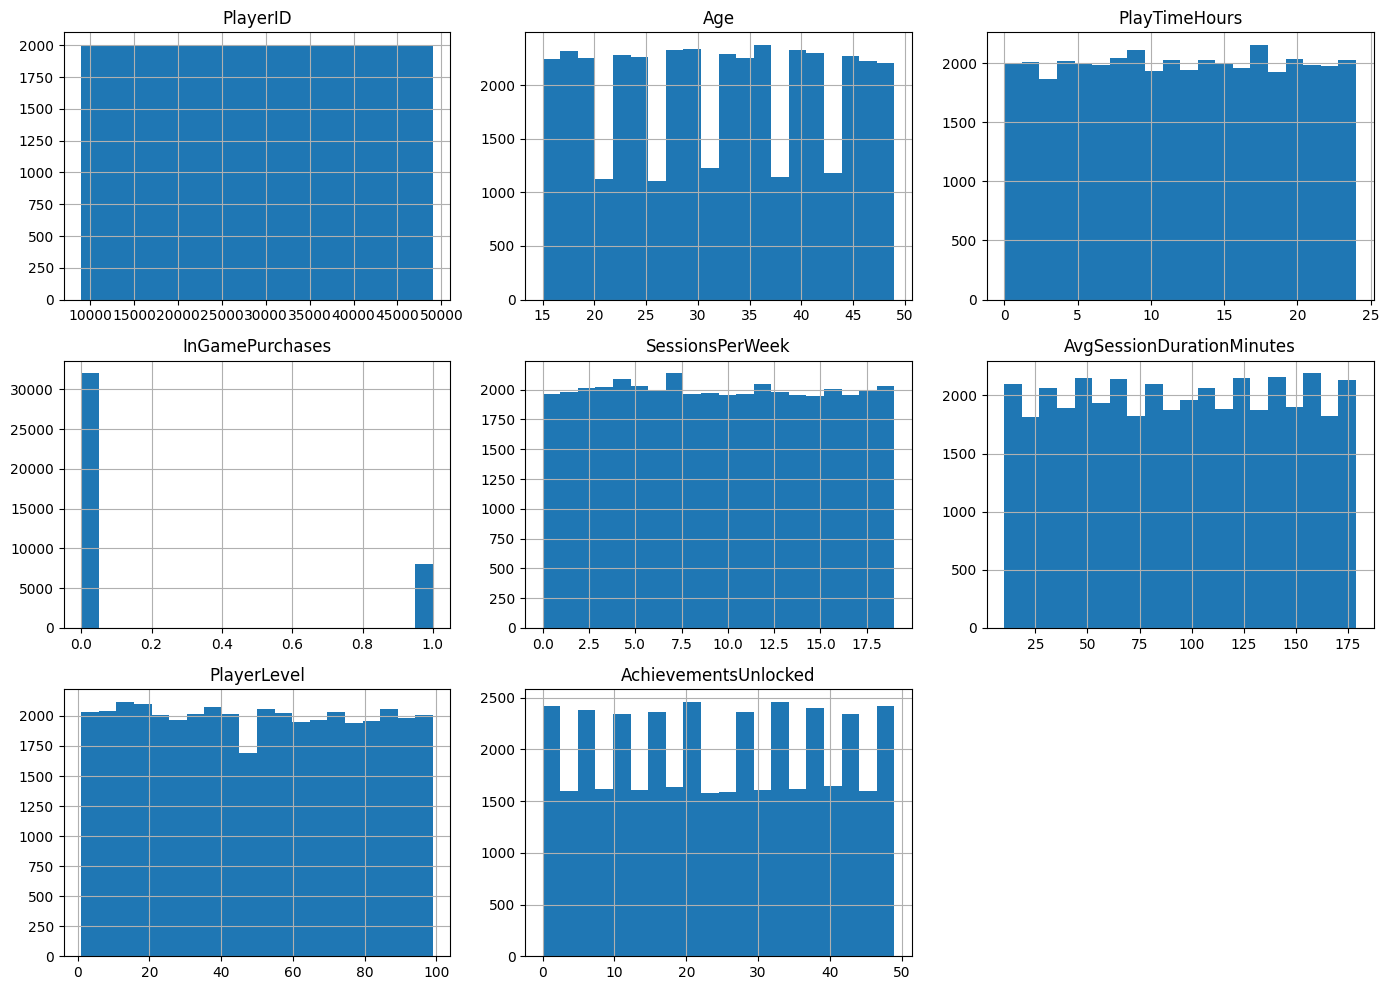

In [90]:

# histograms of our numerical columns 
df.hist(figsize=(14, 10), bins=20)
plt.tight_layout()
plt.show()



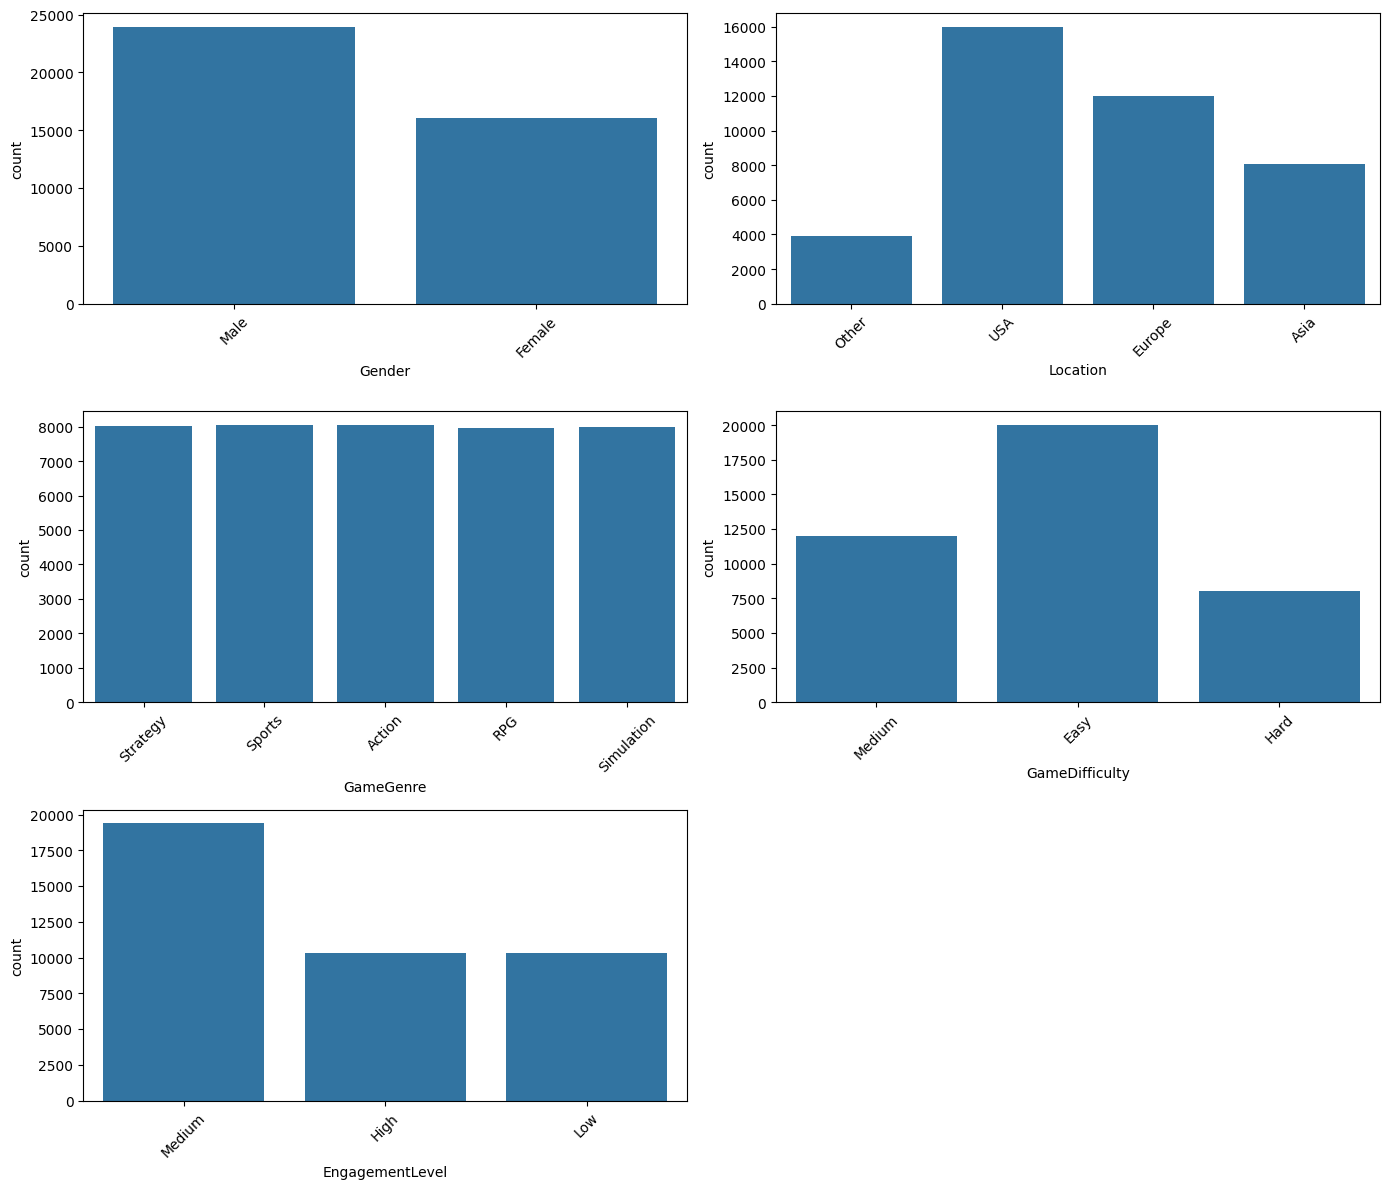

In [91]:
# bar graphs of categorical data
categorical_cols = ["Gender", "Location", "GameGenre", "GameDifficulty", "EngagementLevel"]

plt.figure(figsize=(14, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df, x=col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

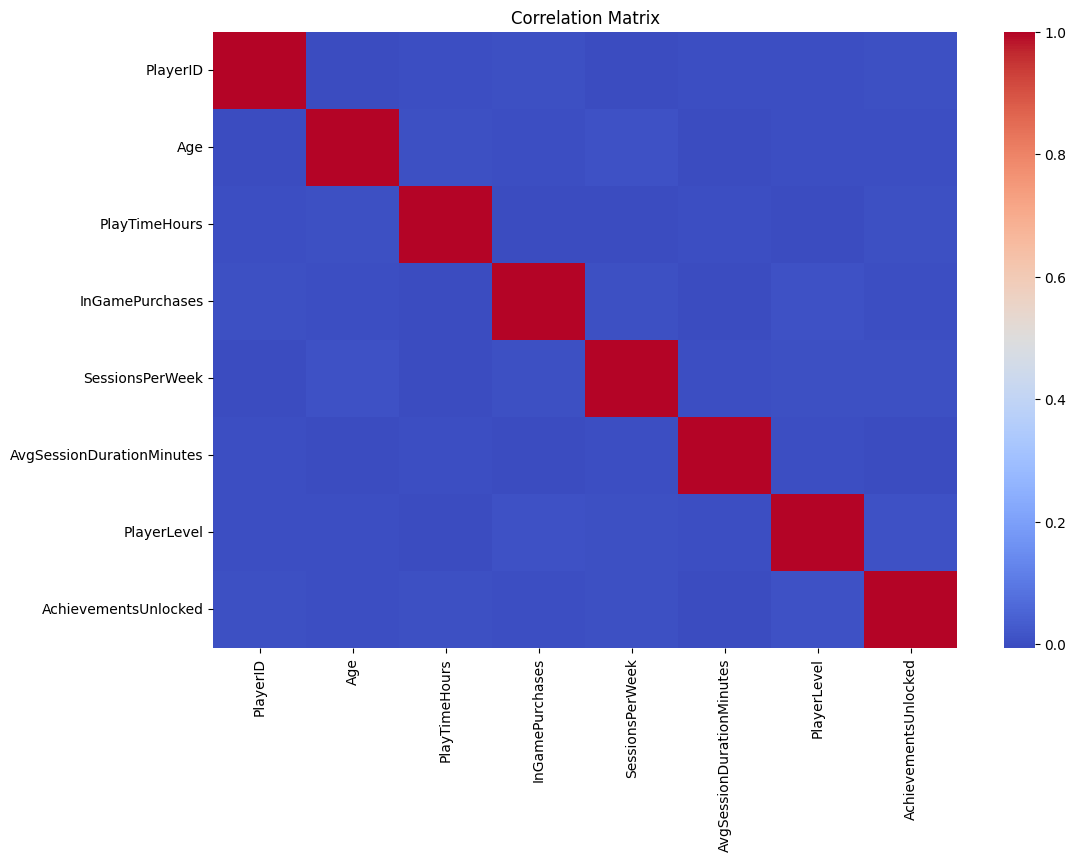

In [92]:
# confusion matrix of our numerical dataset
plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


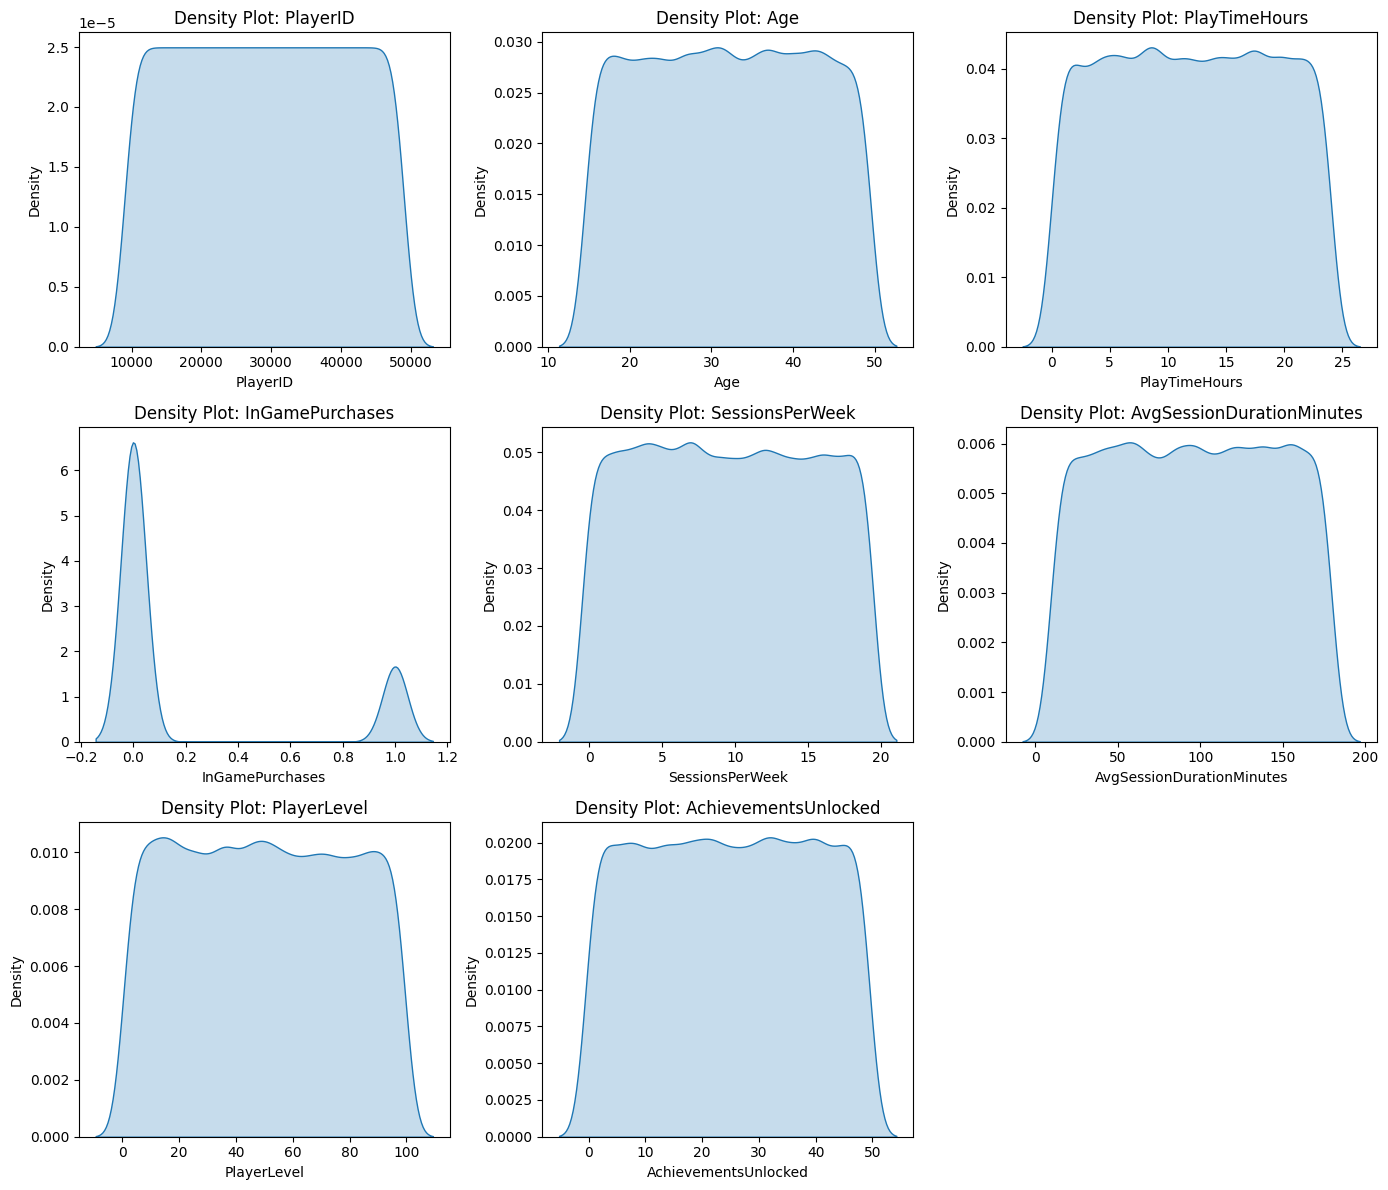

In [93]:
# DENSITY PLOTS (distribution + smooth curves)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(14, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.kdeplot(data=df, x=col, fill=True)
    plt.title(f"Density Plot: {col}")

plt.tight_layout()
plt.show()


# Dataset Preprocessing

In [ ]:
# 1. Copy original df
df_processed = df.copy()

# 2. Dropped PlayerID 
df_processed = df_processed.drop(columns=["PlayerID"])


# 3. Binary classification target:
#    1 = Low engagement
#    0 = Medium or High
df_processed["target"] = (df_processed["EngagementLevel"] == "Low").astype(int)

print("Binary class counts:")
print(df_processed["target"].value_counts(), "\n")


# 4. One-hot encode categorical inputs
df_processed = pd.get_dummies(
    df_processed,
    columns=["Gender", "Location", "GameGenre", "GameDifficulty"],
    drop_first=True
)

# 5. Define X (features) and y (labels)
X = df_processed.drop(columns=["EngagementLevel", "target"])
y = df_processed["target"]

print("Total feature count:", X.shape[1])
print("Example feature cols:", X.columns[:10].tolist(), "\n")

# 6. FIRST SPLIT: Train vs Temp (Val+Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# 7. SECOND SPLIT: Validation vs Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape, "\n")

# Class balance check
print("Train balance:\n", y_train.value_counts(normalize=True))
print("\nValidation balance:\n", y_val.value_counts(normalize=True))
print("\nTest balance:\n", y_test.value_counts(normalize=True), "\n")

# 8. Scale numeric inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Scaled train shape:", X_train_scaled.shape)
print("Scaled val shape:", X_val_scaled.shape)
print("Scaled test shape:", X_test_scaled.shape)

Binary class counts:
target
0    29710
1    10324
Name: count, dtype: int64 

Total feature count: 17
Example feature cols: ['Age', 'PlayTimeHours', 'InGamePurchases', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked', 'Gender_Male', 'Location_Europe', 'Location_Other'] 

Train size: (28023, 17)
Validation size: (6005, 17)
Test size: (6006, 17) 

Train balance:
 target
0    0.742105
1    0.257895
Name: proportion, dtype: float64

Validation balance:
 target
0    0.742215
1    0.257785
Name: proportion, dtype: float64

Test balance:
 target
0    0.742091
1    0.257909
Name: proportion, dtype: float64 

Scaled train shape: (28023, 17)
Scaled val shape: (6005, 17)
Scaled test shape: (6006, 17)


In [96]:
X_train_scaled[:5]


array([[-0.78932062,  0.17935084, -0.50158302,  0.7857381 , -1.62231303,
         1.69228174, -1.21118094,  0.81612028, -0.64926823, -0.33245373,
         1.22121916, -0.49784681, -0.49829322, -0.50258584,  2.00595206,
        -0.49907425,  1.52530881],
       [-1.18673753, -0.36750457,  1.99368789, -0.77529642,  0.23291502,
        -0.26413801,  1.00087734,  0.81612028,  1.5401955 , -0.33245373,
        -0.81885384, -0.49784681, -0.49829322, -0.50258584, -0.4985164 ,
        -0.49907425,  1.52530881],
       [-0.6899664 ,  0.91341856,  1.99368789, -0.0815033 , -0.05250468,
         0.12015873, -1.00380048,  0.81612028, -0.64926823, -0.33245373,
         1.22121916, -0.49784681,  2.00685049, -0.50258584, -0.4985164 ,
        -0.49907425, -0.65560495],
       [-0.2925495 ,  0.1403349 , -0.50158302, -0.9487447 , -0.31753726,
        -0.19426588,  1.00087734,  0.81612028,  1.5401955 , -0.33245373,
        -0.81885384, -0.49784681, -0.49829322, -0.50258584, -0.4985164 ,
        -0.49907425

# LOGISTIC REGRESSION MODEL 

In [97]:
# Base model
log_reg = LogisticRegression(
    penalty="l2",
    C=1,              # Regularization strength (1/λ)
    solver="lbfgs",
    max_iter=1000
)

# Train the model
log_reg.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [98]:
y_pred = log_reg.predict(X_val_scaled)
y_proba = log_reg.predict_proba(X_val_scaled)[:, 1]   # probability of class 1 (Low)


In [100]:
accuracy  = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall    = recall_score(y_val, y_pred)
f1        = f1_score(y_val, y_pred)

print("Logistic Regression Metrics:")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)


Logistic Regression Metrics:
Accuracy : 0.8814321398834305
Precision: 0.8110119047619048
Recall   : 0.7041343669250646
F1 Score : 0.7538035961272476


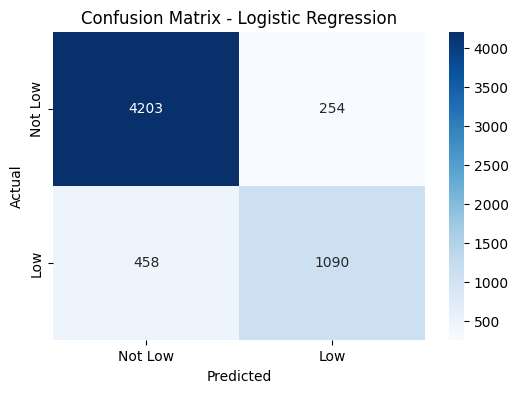

In [101]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Low", "Low"],
            yticklabels=["Not Low", "Low"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


## Tranformations for Logistic Regression

In [102]:
# Degree 2
poly2 = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly2 = poly2.fit_transform(X_train_scaled)
X_val_poly2   = poly2.transform(X_val_scaled)

print("Degree 2 Polynomial Feature Shape:", X_train_poly2.shape)


Degree 2 Polynomial Feature Shape: (28023, 170)


In [103]:
# Degree 3
poly3 = PolynomialFeatures(degree=3, include_bias=False)

X_train_poly3 = poly3.fit_transform(X_train_scaled)
X_val_poly3   = poly3.transform(X_val_scaled)

print("Degree 3 Polynomial Feature Shape:", X_train_poly3.shape)


Degree 3 Polynomial Feature Shape: (28023, 1139)


In [104]:
# choose number of clusters 
n_clusters = 50

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_train_scaled)

X_train_kmeans = kmeans.transform(X_train_scaled)
X_val_kmeans   = kmeans.transform(X_val_scaled)

print("KMeans-dist (k=50) shapes:", X_train_kmeans.shape, X_val_kmeans.shape)


KMeans-dist (k=50) shapes: (28023, 50) (6005, 50)


## Hyperparameter Tuning for Logistic Regression

In [105]:
# 7 lambda values 
lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# C = 1 / lambda
Cs = [1.0 / lam for lam in lambdas]


base_results = []

for lam, C in zip(lambdas, Cs):
    clf = LogisticRegression(
        penalty="l2",
        C=C,
        solver="lbfgs",
        max_iter=2000
    )
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_val_scaled)

    acc  = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)

    base_results.append({
        "feature_space": "original",
        "lambda": lam,
        "C": C,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

base_results_df = pd.DataFrame(base_results)
print(base_results_df)


  feature_space    lambda         C  accuracy  precision    recall        f1
0      original     0.001  1000.000  0.881266   0.810409  0.704134  0.753543
1      original     0.010   100.000  0.881266   0.810409  0.704134  0.753543
2      original     0.100    10.000  0.881266   0.810409  0.704134  0.753543
3      original     1.000     1.000  0.881432   0.811012  0.704134  0.753804
4      original    10.000     0.100  0.881099   0.810730  0.702842  0.752941
5      original   100.000     0.010  0.881599   0.819222  0.693798  0.751312
6      original  1000.000     0.001  0.881765   0.892322  0.615633  0.728593


In [106]:
feature_spaces = {
    "poly_deg2": (X_train_poly2, X_val_poly2),
    "poly_deg3": (X_train_poly3, X_val_poly3),
    "kmeans_dist": (X_train_kmeans, X_val_kmeans),
}

transformed_results = []

for fs_name, (Xt, Xv) in feature_spaces.items():
    for lam, C in zip(lambdas, Cs):
        clf = LogisticRegression(
            penalty="l2",
            C=C,
            solver="lbfgs",
            max_iter=2000
        )
        clf.fit(Xt, y_train)
        y_pred = clf.predict(Xv)

        acc  = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec  = recall_score(y_val, y_pred)
        f1   = f1_score(y_val, y_pred)

        transformed_results.append({
            "feature_space": fs_name,
            "lambda": lam,
            "C": C,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1
        })

transformed_results_df = pd.DataFrame(transformed_results)
print(transformed_results_df.head(21))


   feature_space    lambda         C  accuracy  precision    recall        f1
0      poly_deg2     0.001  1000.000  0.924396   0.897529  0.797804  0.844733
1      poly_deg2     0.010   100.000  0.924396   0.897529  0.797804  0.844733
2      poly_deg2     0.100    10.000  0.924396   0.897529  0.797804  0.844733
3      poly_deg2     1.000     1.000  0.924396   0.897529  0.797804  0.844733
4      poly_deg2    10.000     0.100  0.924230   0.898034  0.796512  0.844231
5      poly_deg2   100.000     0.010  0.925229   0.910995  0.786822  0.844367
6      poly_deg2  1000.000     0.001  0.904246   0.932444  0.677649  0.784886
7      poly_deg3     0.001  1000.000  0.932390   0.904391  0.824935  0.862838
8      poly_deg3     0.010   100.000  0.932390   0.904391  0.824935  0.862838
9      poly_deg3     0.100    10.000  0.932390   0.904391  0.824935  0.862838
10     poly_deg3     1.000     1.000  0.932723   0.905099  0.825581  0.863514
11     poly_deg3    10.000     0.100  0.932889   0.905741  0.825

In [107]:
logreg_results_df = pd.concat(
    [base_results_df, transformed_results_df],
    ignore_index=True
)

print(logreg_results_df)

   feature_space    lambda         C  accuracy  precision    recall        f1
0       original     0.001  1000.000  0.881266   0.810409  0.704134  0.753543
1       original     0.010   100.000  0.881266   0.810409  0.704134  0.753543
2       original     0.100    10.000  0.881266   0.810409  0.704134  0.753543
3       original     1.000     1.000  0.881432   0.811012  0.704134  0.753804
4       original    10.000     0.100  0.881099   0.810730  0.702842  0.752941
5       original   100.000     0.010  0.881599   0.819222  0.693798  0.751312
6       original  1000.000     0.001  0.881765   0.892322  0.615633  0.728593
7      poly_deg2     0.001  1000.000  0.924396   0.897529  0.797804  0.844733
8      poly_deg2     0.010   100.000  0.924396   0.897529  0.797804  0.844733
9      poly_deg2     0.100    10.000  0.924396   0.897529  0.797804  0.844733
10     poly_deg2     1.000     1.000  0.924396   0.897529  0.797804  0.844733
11     poly_deg2    10.000     0.100  0.924230   0.898034  0.796

# KNN

In [108]:

# BASE KNN MODEL
base_k = 5   
knn_base = KNeighborsClassifier(n_neighbors=base_k)

knn_base.fit(X_train_scaled, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [109]:
y_pred_knn = knn_base.predict(X_val_scaled)

acc  = accuracy_score(y_val, y_pred_knn)
prec = precision_score(y_val, y_pred_knn)
rec  = recall_score(y_val, y_pred_knn)
f1   = f1_score(y_val, y_pred_knn)

print(f"KNN BASE MODEL (k={base_k})")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)


KNN BASE MODEL (k=5)
Accuracy : 0.8274771024146544
Precision: 0.7544731610337972
Recall   : 0.4903100775193798
F1 Score : 0.5943617854346124


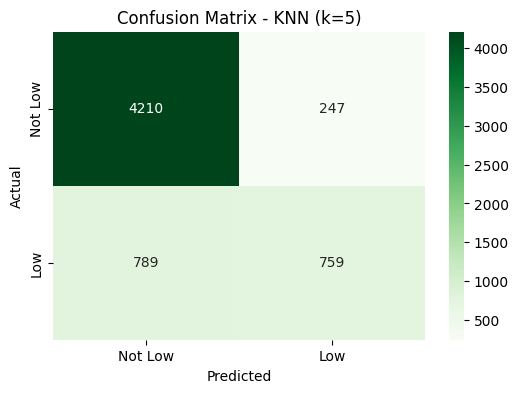

In [110]:
# Confusion matrix
cm_knn = confusion_matrix(y_val, y_pred_knn)

plt.figure(figsize=(6,4))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Not Low","Low"],
            yticklabels=["Not Low","Low"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - KNN (k={base_k})")
plt.show()

## Hyperparameter Tuning for KNN ( Same Transformations as Logistic Regression ) 

In [111]:
k_values = [1, 3, 5, 7, 9, 11, 15]

feature_spaces_knn = {
    "original": (X_train_scaled, X_val_scaled),
    "poly_deg2": (X_train_poly2, X_val_poly2),
    "poly_deg3": (X_train_poly3, X_val_poly3),
    "kmeans_dist": (X_train_kmeans, X_val_kmeans),
}

knn_results = []

for fs_name, (Xt, Xv) in feature_spaces_knn.items():
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(Xt, y_train)
        y_pred = knn.predict(Xv)

        acc  = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec  = recall_score(y_val, y_pred)
        f1   = f1_score(y_val, y_pred)

        knn_results.append({
            "feature_space": fs_name,
            "k": k,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1
        })

knn_results_df = pd.DataFrame(knn_results)
print(knn_results_df)


   feature_space   k  accuracy  precision    recall        f1
0       original   1  0.799500   0.623563  0.560724  0.590476
1       original   3  0.819484   0.705674  0.514212  0.594918
2       original   5  0.827477   0.754473  0.490310  0.594362
3       original   7  0.828143   0.776824  0.467700  0.583871
4       original   9  0.828476   0.797701  0.448320  0.574028
5       original  11  0.830641   0.824969  0.435401  0.569979
6       original  15  0.828809   0.853261  0.405685  0.549912
7      poly_deg2   1  0.802831   0.637255  0.545866  0.588031
8      poly_deg2   3  0.822315   0.723305  0.503230  0.593524
9      poly_deg2   5  0.826478   0.773810  0.461886  0.578479
10     poly_deg2   7  0.825645   0.800000  0.431525  0.560638
11     poly_deg2   9  0.825978   0.821201  0.415375  0.551695
12     poly_deg2  11  0.826478   0.844687  0.400517  0.543383
13     poly_deg2  15  0.823314   0.877519  0.365633  0.516188
14     poly_deg3   1  0.803164   0.641204  0.536822  0.584388
15     p

# Neural Network

In [112]:

mlp_base = MLPClassifier(
    hidden_layer_sizes=(64,),   # 1 hidden layer with 64 neurons
    activation="relu",
    solver="adam",
    alpha=1e-4,                 # baseline regularization
    batch_size=256,
    learning_rate="adaptive",
    max_iter=200,
    random_state=42,
)

mlp_base.fit(X_train_scaled, y_train)

/Users/luislazo/Desktop/ML-Final-Project/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,hidden_layer_sizes,"(64,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,256
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,42


In [113]:
y_pred_mlp_base = mlp_base.predict(X_val_scaled)

acc  = accuracy_score(y_val, y_pred_mlp_base)
prec = precision_score(y_val, y_pred_mlp_base)
rec  = recall_score(y_val, y_pred_mlp_base)
f1   = f1_score(y_val, y_pred_mlp_base)

print("MLP BASE MODEL (1 layer, 64 neurons, ReLU)")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)

MLP BASE MODEL (1 layer, 64 neurons, ReLU)
Accuracy : 0.9362198168193172
Precision: 0.9110797459421313
Recall   : 0.8339793281653747
F1 Score : 0.8708263069139967


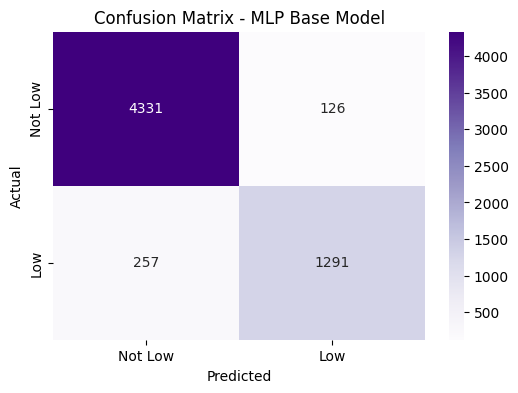

In [114]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred_mlp_base)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Not Low", "Low"],
            yticklabels=["Not Low", "Low"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MLP Base Model")
plt.show()

## Transformations and Hyperparameter Tuning for Neural Network

In [115]:
# 7 regularization strengths
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

# 4 neural network "transformations" = different depths
nn_configs = {
    "mlp_1layer_64": {
        "hidden_layer_sizes": (64,),
    },
    "mlp_2layer_128_64": {
        "hidden_layer_sizes": (128, 64),
    },
    "mlp_2layer_64_32": {
        "hidden_layer_sizes": (64, 32),
    },
    "mlp_3layer_128_64_32": {
        "hidden_layer_sizes": (128, 64, 32),
    },
}

mlp_results = []

for config_name, cfg in nn_configs.items():
    for alpha in alphas:
        mlp = MLPClassifier(
            hidden_layer_sizes=cfg["hidden_layer_sizes"],
            activation="relu",        # same activation for all
            solver="adam",
            alpha=alpha,              # L2 regularization
            batch_size=256,
            learning_rate="adaptive",
            max_iter=200,
            random_state=42,
        )

        mlp.fit(X_train_scaled, y_train)
        y_pred = mlp.predict(X_val_scaled)

        acc  = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec  = recall_score(y_val, y_pred)
        f1   = f1_score(y_val, y_pred)

        mlp_results.append({
            "config": config_name,
            "hidden_layers": cfg["hidden_layer_sizes"],
            "alpha": alpha,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
        })

mlp_results_df = pd.DataFrame(mlp_results)
print(mlp_results_df)

/Users/luislazo/Desktop/ML-Final-Project/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/luislazo/Desktop/ML-Final-Project/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/luislazo/Desktop/ML-Final-Project/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/luislazo/Desktop/ML-Final-Project/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

                  config  hidden_layers     alpha  accuracy  precision  \
0          mlp_1layer_64          (64,)  0.000001  0.933389   0.903657   
1          mlp_1layer_64          (64,)  0.000010  0.934388   0.906338   
2          mlp_1layer_64          (64,)  0.000100  0.936220   0.911080   
3          mlp_1layer_64          (64,)  0.001000  0.934721   0.905899   
4          mlp_1layer_64          (64,)  0.010000  0.936719   0.908392   
5          mlp_1layer_64          (64,)  0.100000  0.939883   0.915907   
6          mlp_1layer_64          (64,)  1.000000  0.934555   0.923698   
7      mlp_2layer_128_64      (128, 64)  0.000001  0.913739   0.837042   
8      mlp_2layer_128_64      (128, 64)  0.000010  0.914738   0.837240   
9      mlp_2layer_128_64      (128, 64)  0.000100  0.918401   0.847569   
10     mlp_2layer_128_64      (128, 64)  0.001000  0.915570   0.833440   
11     mlp_2layer_128_64      (128, 64)  0.010000  0.926894   0.870903   
12     mlp_2layer_128_64      (128, 64